# 作业1:无穷嵌套的根式

2025-9-03

## 问题描述和分析

这里我们分析无穷嵌套根式的性质（$x>0$）：

$$ y=f(x)=\sqrt{x+\sqrt{x+\sqrt{x+\cdots}}} $$

当然，上述的无穷嵌套根式并不能直接进行数值计算，这里我们将其化为数列：

$$y_0,\quad y_1 = \sqrt{x+y_0},\quad y_2 = \sqrt{x+\sqrt{x+y_0}},\quad\dots$$

显然其递推公式如下：

$$ y_{n+1} = \sqrt{x+y_{n}} $$

我们定义一个新的函数 $f_n(x)$ 表示迭代了 $n$ 次的嵌套根式，即 $y_n = f_n(x)$，这个函数是很容易进行数值计算的.

而无穷嵌套根式的函数值就是上述数列的极限：

$$ f(x) = \lim_{n\to\infty} y_n = \lim_{n\to\infty} f_n(x) $$

## 数值探索

### 计算前准备

导入需要的库，并针对 Jupyter Notebook 进行一些设置.

In [1]:
import numpy as np # 数值计算库
import numba as nb # 引入 jit 来加速函数（如果需要）
import sympy as sym # 符号计算库
import matplotlib.pyplot as plt # 图像绘制
import ipywidgets as ipw # 交互控件

# 使用 mathjax 来在 jupyter notebook 显示数学公式
sym.init_printing(use_latex='mathjax')

# 设置 matplotlib 绘制的图像嵌入到 jupyter notebook 的方式
%matplotlib widget

# 设置 matplotlib 使用的字体，避免出现中文问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 问题（1）

这里我们先根据前文分析实现 $f_n(x)$，并定义一个函数，其传入一个值（数组），以及需要迭代的次数，返回指定迭代次数的根式嵌套的值.

我们先人为采用一个足够大的 $n$，并认为其收敛.

In [2]:
def fn(x, n=20, y0=1):
    x = np.array(x, ndmin=1) # 保证至少是 1D 的 Array
    y = np.ones_like(x) * y0
    for i in range(n):
        y = np.sqrt(x+y)
    return y

传入课件中的第一小问的值 $x=42$，验证 $y\to7$

In [3]:
fn(42)

array([7.])

这符合题目的预期值 $7$，也说明上述函数是符合要求的. 当然，我们也可以绘制出迭代收敛的过程，从而说明我们取的 $n$ 已足够大使得数值是收敛的：

Text(0.5, 1.0, '迭代次数和函数值的关系')

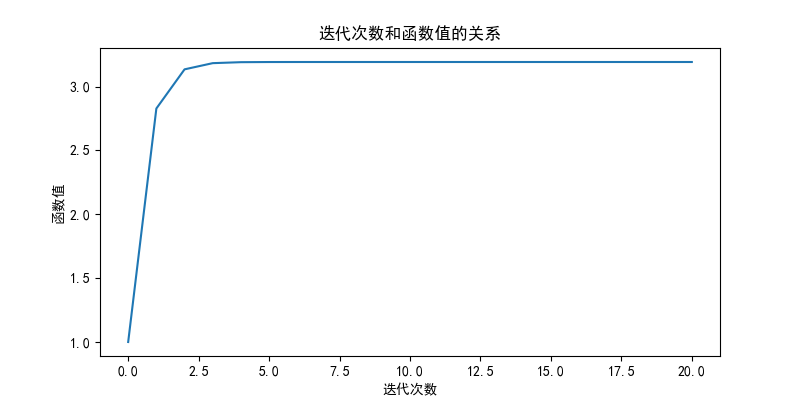

In [4]:
def fn_track(x, n=20, y0=1):
    x = np.array(x, ndmin=1)
    n_arr = np.arange(n+1)
    y_arr = np.zeros((n+1, len(x)))
    y_arr[0] = y0 * np.ones_like(x)
    for i in range(n):
        y_arr[i+1] = np.sqrt(x + y_arr[i])
    return n_arr, y_arr

n_arr, y_arr = fn_track(7)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(n_arr, y_arr)
ax.set_xlabel("迭代次数")
ax.set_ylabel("函数值")
ax.set_title("迭代次数和函数值的关系")

### 问题（2）

现在我们来探究当 $x$ 取其他的值时的收敛情况，上述函数的实现过程中实际上是向量化的，因此我们只需传入数组即可.

Text(0.5, 1.0, '迭代次数和函数值的关系')

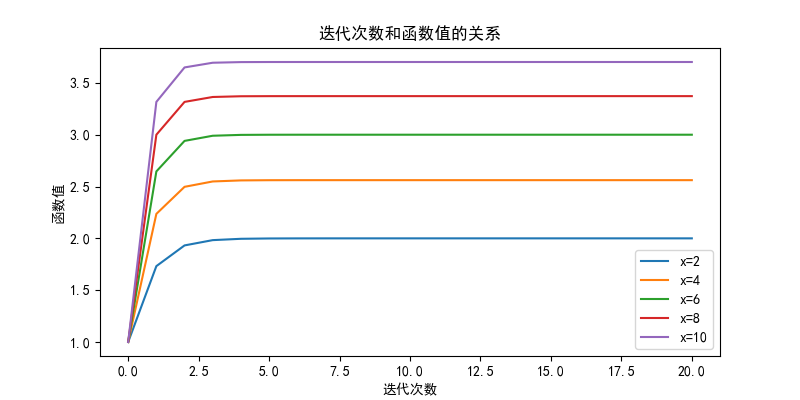

In [5]:
x_arr = np.arange(2,11,2) # 计算输入为 2,4,6,8,10 的情况
n_arr, y_arr = fn_track(x_arr)
fig, ax = plt.subplots(figsize=(8,4))
for i, x in enumerate(x_arr):
    ax.plot(n_arr, y_arr[:,i], label=f"x={x}")
ax.set_xlabel("迭代次数")
ax.set_ylabel("函数值")
ax.legend()
ax.set_title("迭代次数和函数值的关系")

我们也可以使用交互控件动态地进行绘制.

interactive(children=(FloatSlider(value=10.0, description='x', max=20.0), Output()), _dom_classes=('widget-int…

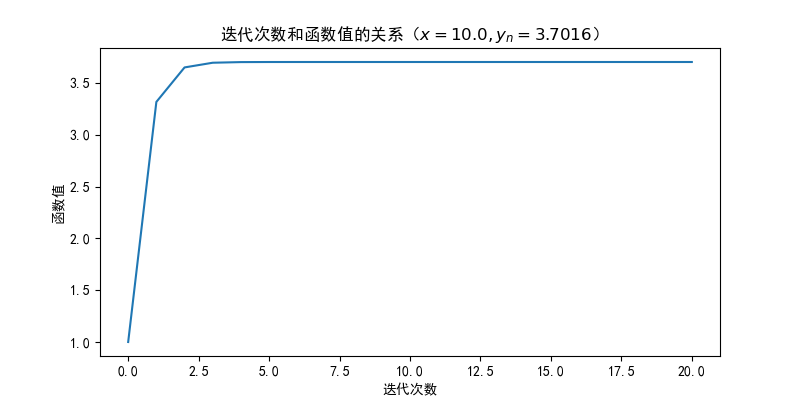

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

@ipw.interact(x=(0,20,0.1))
def update_plot(x):
    ax.clear() # 清除画布
    n_arr, y_arr = fn_track(x)
    ax.plot(n_arr, y_arr, label=f"x={x}")
    ax.set_xlabel("迭代次数")
    ax.set_ylabel("函数值")
    ax.set_title(f"迭代次数和函数值的关系（$x={x}, y_n={y_arr[-1][0]: .4f}$）")

当然，在以上的所有的函数中，我们都人为给定了迭代次数 $n$，并通过绘制图像来说明当 $n$ 足够大时收敛. 这并不方便我们之后的讨论（固定 $n$ 无法说明已经收敛，也不可能每给定一个 $n$ 都绘图验证收敛）. 因此我们可以通过计算两次迭代的差，当迭代的差小于某个给定的精度时，认为到该精度已经收敛. 同时也提高了效率（当数值基本稳定时就停止计算）.

具体而言，给定容差 $\epsilon$，当 $|f_n(x) - f_{n-1}(x)|<\epsilon$ 时，认为：
$$ f(x) \approx f_n(x) $$


In [7]:
def f(x, tol=1e-10, y0=1.0, maxn = 1e4): # 为了方便后面使用，同样写成向量化的形式
    x = np.array(x, ndmin=1)
    y = np.ones_like(x) * y0
    for i in range(int(maxn)): # 最大循环次数，防止无限循环
        y_old = y.copy()
        y = np.sqrt(x+y)
        if np.all(np.abs(y-y_old) < tol):
            return y
    print("达到最大迭代次数仍未收敛.")
    return y

带入已知值验证一下.

In [8]:
f(42)

array([7.])

现在我们在 $[0,1000]$ 范围内均匀取样，并绘制函数关系曲线.

Text(0.5, 1.0, 'x 和 y 关系')

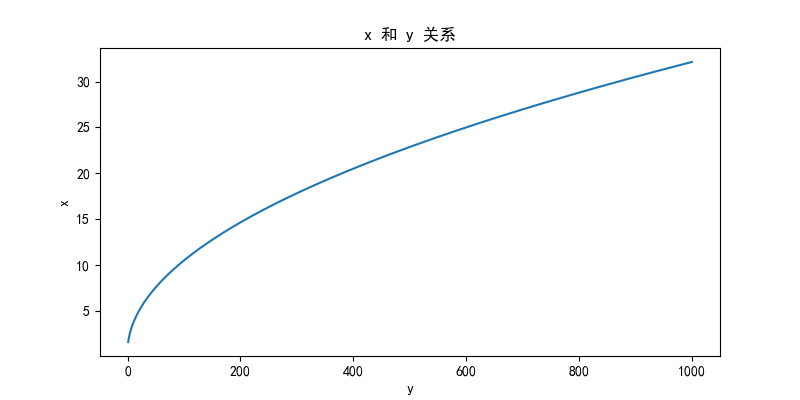

In [9]:
x_arr = np.arange(1,1001)
y_arr = f(x_arr)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_arr, y_arr)
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_title(f"x 和 y 关系")

### 问题（3）

从图像中可以看出 $x$ 和 $y$ 大致是某种幂率关系，取对数绘图并线性拟合.

k=np.float64(0.47397674414472446),b=np.float64(0.1847030256832073)


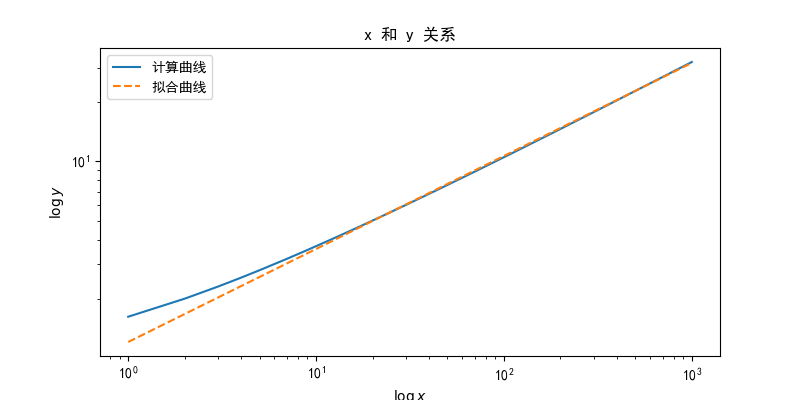

In [10]:
k, b = np.polyfit(np.log(x_arr), np.log(y_arr), 1)
fit = lambda x: np.exp(k * np.log(x) + b)
fig, ax = plt.subplots(figsize=(8,4))
ax.loglog(x_arr, y_arr, label="计算曲线")
ax.loglog(x_arr, fit(x_arr), '--', label="拟合曲线")
ax.set_xlabel("$\\log x$")
ax.set_ylabel("$\\log y$")
ax.legend()
ax.set_title(f"x 和 y 关系")
print(f"{k=},{b=}")

可以得到当 $x\to\infty$ 时 $y\approx k \sqrt{x}$（$k$ 为某个常数）

## 解析分析

现在我们通过解析的方式来推导. 由前文我们得到递推关系：

$$ y_{n+1} = \sqrt{x+y_{n}} $$

即：

$$ y^2_{n+1} = x + y_n $$

两端取 $n\to\infty$ 的极限，记 $y_n \to y\ (n\to\infty)$

$$ y^2 = x + y $$

使用 sympy 求解（当然也可以直接手算）

In [11]:
sym.var("x,y")
sym.solve(y**2-x-y,y)

⎡      _________    _________    ⎤
⎢1   ╲╱ 4⋅x + 1   ╲╱ 4⋅x + 1    1⎥
⎢─ - ───────────, ─────────── + ─⎥
⎣2        2            2        2⎦

> `sym.var("x,y")` 是在 sympy 文档中发现的创建 sympy 符号的及其方便的方法，但即使是 AI 默认都不用，除非手动提出……

显然 $y>0$，取正值，因此：
$$ y=f(x)= \frac{\sqrt{1+4x}+1}{2}$$
这也符合前文数值拟合得到的当 $x\to\infty$ 时 $y\approx k \sqrt{x}$ 的认识.

将解析的结果和数值的结果进行对比：

Text(0.5, 1.0, 'x 和 y 关系（解析解和数值解对比）')

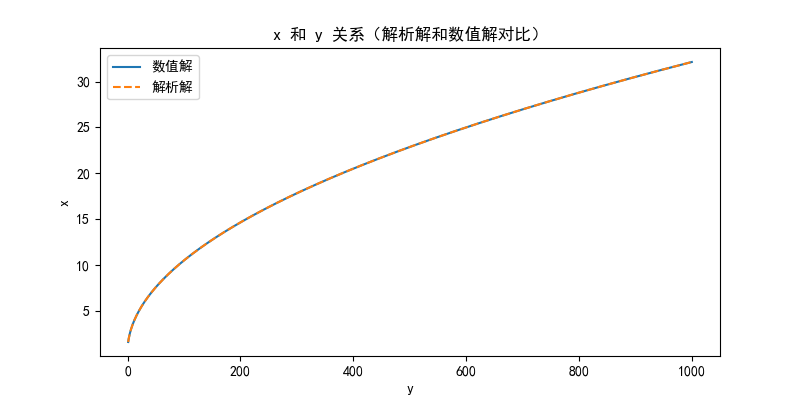

In [12]:
f_exact = lambda x: 0.5 * (np.sqrt(1+4*x) + 1)
x_arr = np.arange(1,1001)
y_ns = f(x_arr)
y_as = f_exact(x_arr)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_arr, y_ns, label="数值解")
ax.plot(x_arr, y_as, '--', label="解析解")
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.legend()
ax.set_title(f"x 和 y 关系（解析解和数值解对比）")

可以发现两者完美重合，进一步地分析两者误差的最值：

In [13]:
np.max(y_ns - y_as)

np.float64(7.105427357601002e-15)

基本是双精度浮点计算的误差水平，因此解析解和数值解完美吻合.

## 其他探索

实际上，我们可以换一种方式进行理解，数列的递推关系式为：

$$ y_{n+1} = g(y_n),\quad g(y) \coloneqq \sqrt{x+y} $$

而极限值 $y$ 就是函数 $g(y)$ 的**不动点**. 因此我们可以画出 $g(y)$ 和 $y$ 的函数图像，两者交点就是所求的极限值.


interactive(children=(FloatSlider(value=10.0, description='x', max=20.0, min=0.1), Output()), _dom_classes=('w…

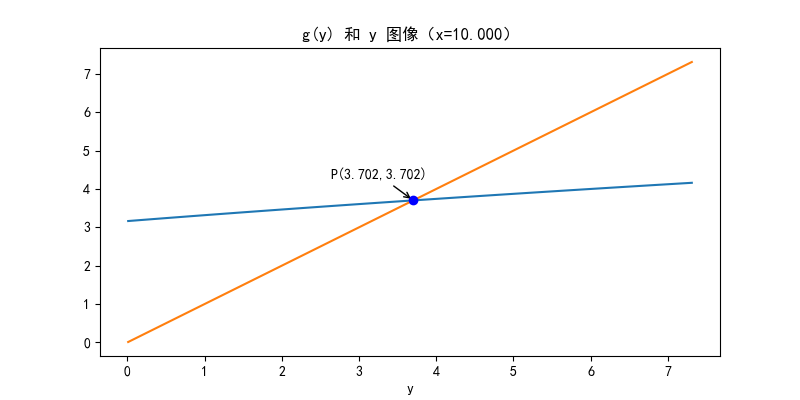

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

@ipw.interact(x=(0.1,20,0.1))
def update_plot(x):
    ax.clear()
    g = lambda y: np.sqrt(x+y)
    yp = f_exact(x)
    x_arr = np.arange(0.01, 2*yp, 0.1)
    ax.plot(x_arr, g(x_arr), label=f"g(y)")
    ax.plot(x_arr, x_arr, label=f"y")
    ax.plot(yp, yp, 'bo', label=f'交点', zorder=5)
    ax.annotate(f'P({yp:.3f},{yp:.3f})',
                xy=(yp, yp),
                xytext=(-60, 15),
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
    ax.set_xlabel("y")
    ax.set_title(f"g(y) 和 y 图像（x={x:.3f}）")
    

interactive(children=(FloatSlider(value=5.0, description='x', max=10.0, min=0.1), FloatSlider(value=7.5, descr…

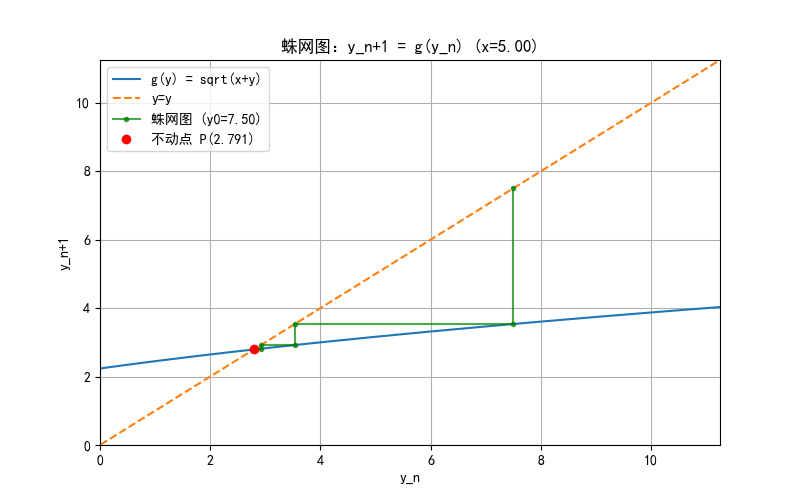

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

@ipw.interact(
    x=(0.1, 10.0, 0.1), 
    y0=(0.1, 15.0, 0.1),
    iterations=(5, 50, 1) # 增加一个控制迭代次数的滑块
)
def update_plot(x, y0, iterations):
    ax.clear()
    g = lambda y: np.sqrt(x + y)
    yp = f_exact(x) # yp 是不动点 (交点)

    y_range_max = max(2 * yp, 1.5 * y0)
    y_arr = np.linspace(0.01, y_range_max, 400)
    ax.plot(y_arr, g(y_arr), label="g(y) = sqrt(x+y)")
    ax.plot(y_arr, y_arr, label="y=y", linestyle='--')

    path_x, path_y = [y0], [y0]
    current_y = y0

    for _ in range(iterations):
        next_y = g(current_y)
        path_x.append(current_y)
        path_y.append(next_y)
        path_x.append(next_y)
        path_y.append(next_y)
        current_y = next_y
        if abs(current_y - yp) < 1e-5:
            break
    ax.plot(path_x, path_y, 'g-o', alpha=0.7, markersize=3, label=f'蛛网图 (y0={y0:.2f})')
    ax.plot(yp, yp, 'ro', label=f'不动点 P({yp:.3f})', zorder=5)
    ax.set_xlabel("y_n")
    ax.set_ylabel("y_n+1")
    ax.set_title(f"蛛网图：y_n+1 = g(y_n) (x={x:.2f})")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, y_range_max)
    ax.set_ylim(0, y_range_max)

mamba install ipympl jupyterlab_widgets ipywidgets jupyterlab_execute_time jupyterlab-variableinspector jupyterlab-lsp python-lsp-server